In [1]:
import pandas as pd
pd.set_option('display.max_rows', 3000)
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

raw_excel_data = pd.read_csv('delhi_cleaned.csv')
df_complex=raw_excel_data.copy()
df_complex.date = pd.to_datetime(df_complex.date,format='%d-%m-%Y %H:%M')
df_complex.set_index("date", inplace=True)
df=df_complex.copy()

In [2]:
size = int(len(df)*0.8)
ts15_train = df.iloc[:size]
ts15_test =df.iloc[size:]

#from sklearn.model_selection import TimeSeriesSplit

#tscv = TimeSeriesSplit(n_splits=5)
#print(tscv)


#data_use = df.reset_index()['pm25']

#for train_index, test_index in tscv.split(data_use):
#    ts15_train = data_use[train_index]
#    ts15_test = data_use[test_index]

In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=24):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = rolling).mean()
    rolstd = timeseries.rolling(window = rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='darkgray',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean', lw=1)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Differenced # of Uber Pickups\nx(t) - x(t-1)')
    plt.xlim(timeseries.index.min(), timeseries.index.max())
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    print('> ADF Statistic: {:.3f}'.format(result[0]))
    print('> p-value: {:.3e}'.format(result[1]))
    print('> Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

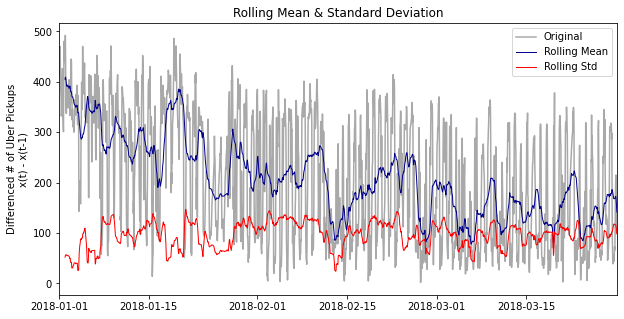

Results of Dickey-Fuller Test:
> ADF Statistic: -3.422
> p-value: 1.024e-02
> Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [4]:
test_stationarity(ts15_train, rolling=24)


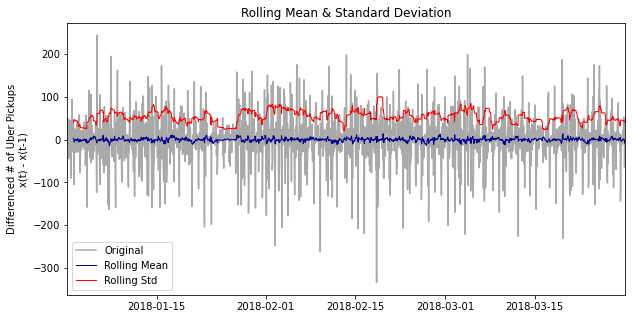

Results of Dickey-Fuller Test:
> ADF Statistic: -13.540
> p-value: 2.520e-25
> Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [5]:
diff15 = ts15_train-ts15_train.shift(1)
diff15.dropna(inplace=True)

test_stationarity(diff15)

In [6]:
#diff15 = ts15_train.pm25-diff15.shift(24)
#diff15.dropna(inplace=True)

#test_stationarity(diff15)

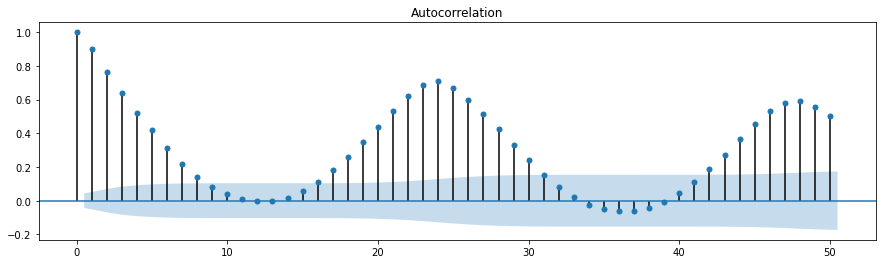

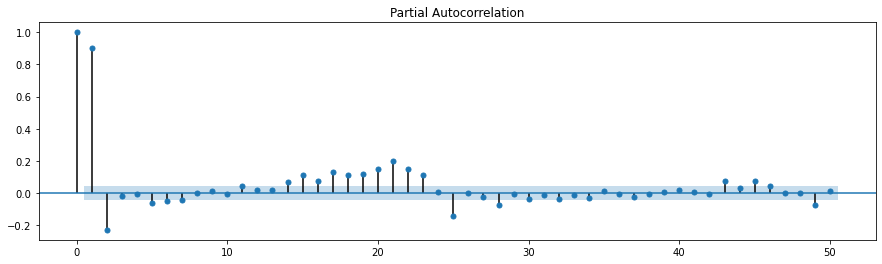

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plot_acf(ts15_train, lags = 50);
plot_pacf(ts15_train, lags = 50);

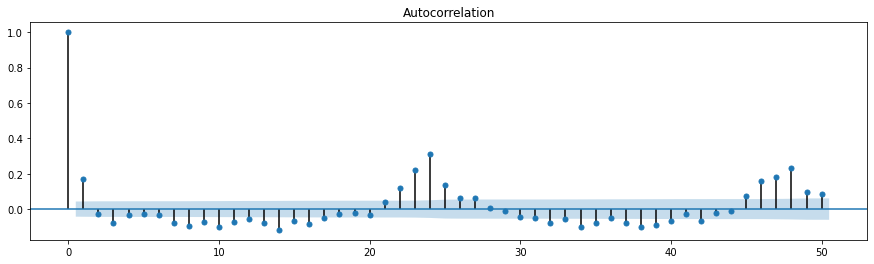

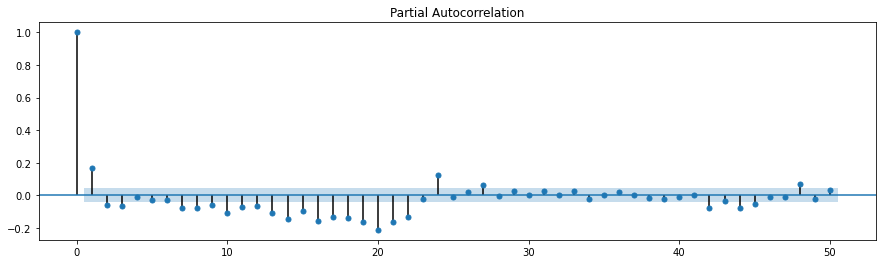

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plot_acf(diff15, lags = 50);
plot_pacf(diff15, lags = 50);

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Test vs Forecast', 
                  xlabel='Date', ylabel='pm25', 
                  grid=True, figsize=(15, 4)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xticks(actual.index.date[::24], 
    #           actual.index.day[::24])
    #plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

### ARIMA

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

In [21]:
sar_m = sarimax.SARIMAX(ts15_train.values,
                        trend='n', 
                        order=(4,1,4), # Got this from grid search
                        seasonal_order=(0, 0, 0, 0), 
                        simple_differencing=False).fit()

C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<Figure size 1080x288 with 0 Axes>

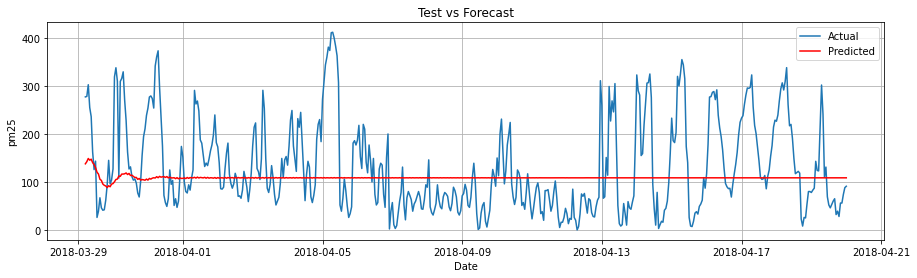

In [22]:
plt.figure(figsize=(15,4))
predict_steps = len(ts15_test)
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(ts15_test[:len(ts15_test)], forecast[:len(ts15_test)])

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE =  sqrt(mean_squared_error(ts15_test, forecast))

print(RMSE)

95.65682452697087


### SARIMA

In [24]:
# create SARIMAX model with previously determined lags
sar_m = sarimax.SARIMAX(ts15_train.values,
                        trend='n', 
                        order=(4,1,4), 
                        seasonal_order=(1, 0, 1, 24), 
                        simple_differencing=False).fit()

C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<Figure size 1080x288 with 0 Axes>

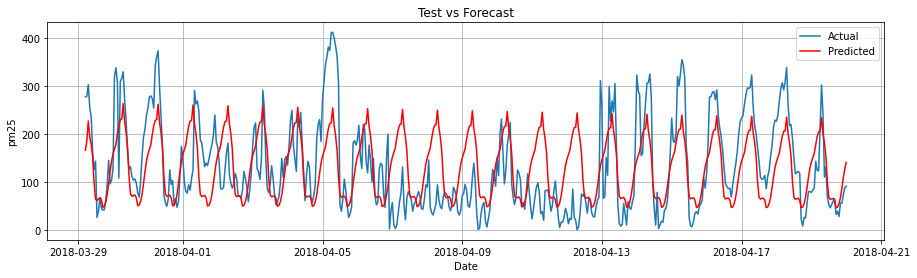

In [25]:
plt.figure(figsize=(15,4))
predict_steps = len(ts15_test)
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(ts15_test[:len(ts15_test)], forecast[:len(ts15_test)])

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE =  sqrt(mean_squared_error(ts15_test, forecast))

print(RMSE)

79.2342083913775


###  Forecast for next 24 hours

In [67]:
# create SARIMAX model with previously determined lags
sar_m = sarimax.SARIMAX(df.values,
                        trend='n', 
                        order=(1,0,1), 
                        seasonal_order=(1, 1, 1, 24), 
                        simple_differencing=False).fit()

In [68]:
forecast = sar_m.forecast(steps=24)

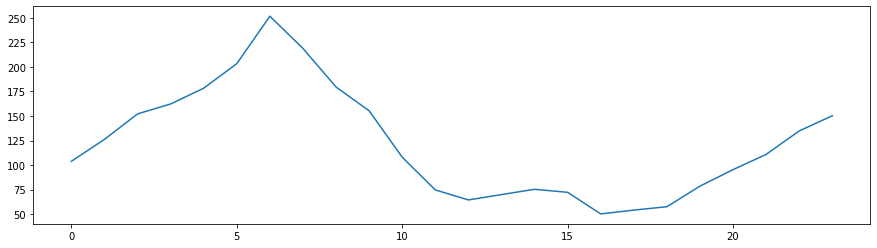

In [69]:
plt.plot(forecast)

In [70]:
forecast

array([103.86979805, 126.19155212, 152.16895495, 162.26632311,
       178.34462778, 203.3406543 , 251.649646  , 218.87530204,
       179.55339791, 155.35819547, 108.07290396,  74.73425477,
        64.49587207,  69.97959816,  75.33044415,  72.27755243,
        50.26511246,  54.13204213,  57.60130909,  78.5557821 ,
        95.36412396, 110.87991977, 134.80212125, 150.22981711])